In [38]:
import pandas as pd

# 1) Get all numeric campaignIDs for ZPI_220801_115
camp_df = pd.read_csv('campaign_info.csv')
valid_ids = (
    camp_df.loc[camp_df['campaignCode']=='ZPI_220801_115','campaignID']
    .astype(int)
    .unique()
    .tolist()
)
print("Using campaignIDs:", valid_ids)

# 2) Load & filter transaction.csv
txn_raw = pd.read_csv('transaction.csv', low_memory=False)
txn = txn_raw[txn_raw['campaignID'].isin(valid_ids)].copy()
print(f"Pulled {len(txn):,} txns for our promo → {txn['userID'].nunique():,} unique users")

# 3) Rename metrics & join key
txn.rename(columns={
    'userID':'userId',
    'amount':'gross_amount',
    'discountAmount':'discount_amount'
}, inplace=True)

# 4) Clean & parse reqDate → txn_ts & txn_hour
txn = txn[
    txn['reqDate'].notna() &
    ~txn['reqDate'].eq('reqDate')
].copy()
txn['txn_ts']   = pd.to_datetime(
    txn['reqDate'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)
txn = txn[txn['txn_ts'].notna()]
txn['txn_hour'] = txn['txn_ts'].dt.hour

print(f"After parsing: {len(txn):,} valid txns × {txn['userId'].nunique():,} users")

# 5) Load map_card.csv, filter & rename
map_csv = pd.read_csv('map_card.csv')
map_csv.rename(columns={
    'userID':'userId',
    'bimID':'card_bin',
    'bankname':'bank_name'
}, inplace=True)

map_df = map_csv.loc[
    map_csv['requestStatus']==1,
    ['userId','card_bin','bank_name']
].drop_duplicates()
print(f"Loaded {len(map_df):,} successful card links for {map_df['userId'].nunique():,} users")

# 6) Left-join to enrich
txn_enriched = txn.merge(map_df, on='userId', how='left')
print(f"txn_enriched → {txn_enriched.shape[0]:,} rows × {txn_enriched.shape[1]} cols")
txn_enriched.head()

Using campaignIDs: [8902, 8911, 8915, 8924, 8932, 8935, 8961, 8899, 8947, 8962, 9077, 9078, 8943, 9073, 9076, 8901, 8903, 8909, 8912, 8941, 8957, 11156, 8904, 8921, 8939, 8945, 8951, 8954, 9069, 9074, 10430, 8907, 8916, 8936, 8940, 8952, 9268, 8910, 8914, 8923, 8958, 8959, 8960, 9989, 11155, 8937, 8946, 9072, 8898, 8922, 8929, 8933, 8949, 8953, 9075, 11158, 8905, 8906, 8908, 8934, 8938, 8942, 8944, 8963, 8964, 9080, 8900, 8918, 8919, 8948, 8955, 9068, 11157]
Pulled 254,309 txns for our promo → 90,555 unique users
After parsing: 254,309 valid txns × 90,555 users
Loaded 76,042 successful card links for 69,988 users
txn_enriched → 273,490 rows × 19 cols


,transID,userId,appID,transStatus,deviceID,platform,osVer,deviceModel,userChargeAmount,gross_amount,reqDate,userIP,campaignID,discount_amount,cashbackTime,txn_ts,txn_hour,card_bin,bank_name
0,92d2f6ddd3c526f2264cdc4cd5820a64,6144f675fe4190f53ec47737eeb234a3,NaN,1,NaN,NaN,NaN,NaN,0,50000,2022-06-01 00:00:00,NaN,9080,50000,2022-06-01 00:00:00,2022-06-01 00:00:00,0,NaN,NaN
1,0c32a6fa0b60e561a8321c9db11d9f62,e06d716076accfb125604d0c1273002e,61.0,-332,5444d13d940c2022,platform2,NaN,NaN,10000,20000,2022-06-01 00:00:04,14.191.228.77,8932,10000,NaN,2022-06-01 00:00:04,0,4f9b6e9fe489622838fca075f0d550e1,YUGfsp
2,0c32a6fa0b60e561a8321c9db11d9f62,e06d716076accfb125604d0c1273002e,61.0,-332,5444d13d940c2022,platform2,NaN,NaN,10000,20000,2022-06-01 00:00:04,14.191.228.77,8932,10000,NaN,2022-06-01 00:00:04,0,2a68efd29cc691f18c638cdc731445b5,FHG
3,d44e3f8e4126aab5ca1e1b13300b53c4,4ca7e616bd4e23bc2bba9954dc5f5198,61.0,1,9226a523aab52265,platform2,NaN,NaN,10000,20000,2022-06-01 00:03:44,42.112.91.161,8932,10000,NaN,2022-06-01 00:03:44,0,NaN,NaN
4,346f8dee597dbd509e6607c482d948db,d65da4bb3987bf16f76361c7ef060964,1889.0,1,b2eebbeb004402dc,platform2,NaN,NaN,28083,48083,2022-06-01 00:07:25,113.185.109.151,8935,20000,NaN,2022-06-01 00:07:25,0,NaN,NaN


In [48]:
# ─── 1) Load and prepare campaign IDs ─────────────────────────────────────────
camp = pd.read_csv('campaign_info.csv')
valid_ids = camp.loc[
    camp['campaignCode']=='ZPI_220801_115',
    'campaignID'
].astype(int).unique().tolist()

# ─── 2) Load & clean transaction data ────────────────────────────────────────
txn = (
    pd.read_csv('transaction.csv', low_memory=False)
      .loc[lambda df: df['campaignID'].isin(valid_ids)]
      .rename(columns={
         'userID':'userId',
         'amount':'gross_amount',
         'discountAmount':'discount_amount'
       })
      .loc[lambda df: df['reqDate'].notna() & (df['reqDate']!='reqDate')]
)
txn['txn_ts']   = pd.to_datetime(
    txn['reqDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce'
)
txn = txn.loc[txn['txn_ts'].notna()]
txn['txn_hour'] = txn['txn_ts'].dt.hour

# ─── 3) Enrich with map_card ─────────────────────────────────────────────────
map_df = (
    pd.read_csv('map_card.csv')
      .rename(columns={
        'userID':'userId',
        'bimID':'card_bin',
        'bankname':'bank_name'
      })
      .loc[lambda df: df['requestStatus']==1, ['userId','card_bin','bank_name']]
)
txn_enriched = txn.merge(map_df, on='userId', how='left')

# ─── 4) Load & clean referral_mapcard ───────────────────────────────────────
ref = (
    pd.read_csv('referral_mapcard.csv', low_memory=False)
      .rename(columns={
         'userID':'inviterId',
         'refereeld':'inviteeId',
         'reqDate':'timestamp'
       })
)
ref['ts'] = pd.to_datetime(ref['timestamp'], format='%m/%d/%Y %H:%M', errors='coerce')
ref = ref.loc[ref['ts'].notna()]

In [58]:
# ─── 5) Detection Rules R1–R6 ────────────────────────────────────────────────
import matplotlib.pyplot as plt
# — R1: Fast referral streaks (≥3 invitees in 15 min) —
ref = (pd.read_csv('referral_mapcard.csv', low_memory=False)
       .rename(columns={
          'userID':    'inviterId',
          'refereeId': 'inviteeId',
          'reqDate':   'ts_str'
       }))
ref['ts'] = pd.to_datetime(ref['ts_str'], format='%m/%d/%Y %H:%M', errors='coerce')
ref = ref.dropna(subset=['ts'])

grp1 = (ref.groupby('inviterId')
           .agg(first_ts=('ts','min'),
                last_ts =('ts','max'),
                n_inv   =('inviteeId','nunique'))
           .reset_index())
r1 = grp1[
    (grp1.n_inv >= 3) &
    ((grp1.last_ts - grp1.first_ts).dt.total_seconds() <= 15*60)
][['inviterId']].copy()
r1['reason'] = 'R1_fast_streak'
r1.rename(columns={'inviterId':'userId'}, inplace=True)


# — R2: Device reuse (same deviceID on ≥2 users) —
dev_ct = (txn_enriched
          .dropna(subset=['deviceID'])
          .groupby('deviceID')['userId']
          .nunique()
          .reset_index(name='cnt'))
multi_dev = dev_ct.query('cnt >= 2')['deviceID']
r2 = (txn_enriched[txn_enriched.deviceID.isin(multi_dev)]
      [['userId']]
      .drop_duplicates()
      .assign(reason='R2_device_reuse'))


# — R3: Min‐fund‐only (all gross_amount == 10000) —
agg3 = (txn_enriched
        .groupby('userId')['gross_amount']
        .agg(min_cnt=lambda s: (s == 10000).sum(),
             tot_cnt='size')
        .reset_index())
r3 = agg3.query('min_cnt >= 1 and min_cnt == tot_cnt')[['userId']].copy()
r3['reason'] = 'R3_min_fund_only'


# — R4: Card reuse (same card_bin on >1 user) —
bin_ct = (txn_enriched
          .dropna(subset=['card_bin'])
          .groupby('card_bin')['userId']
          .nunique()
          .reset_index(name='cnt'))
multi_bin = bin_ct.query('cnt > 1')['card_bin']
r4 = (txn_enriched[txn_enriched.card_bin.isin(multi_bin)]
      [['userId']]
      .drop_duplicates()
      .assign(reason='R4_card_reuse'))


# — R5: Promo‐heavy (sum(discount)/sum(gross) ≥ 0.5) —
agg5 = txn_enriched.groupby('userId').agg(
    total_disc = ('discount_amount','sum'),
    total_gross= ('gross_amount' ,'sum')
).reset_index()
r5 = agg5.query('total_disc/total_gross >= 0.5')[['userId']].copy()
r5['reason'] = 'R5_promo_heavy'


# — R6: Night‐time clusters (≥5 txns between 02:00–05:00) —
night = txn_enriched[txn_enriched['txn_hour'].between(2,5)]
r6 = (night.groupby('userId').size()
          .reset_index(name='cnt')
          .query('cnt >= 5')
          [['userId']])
r6['reason'] = 'R6_night_cluster'

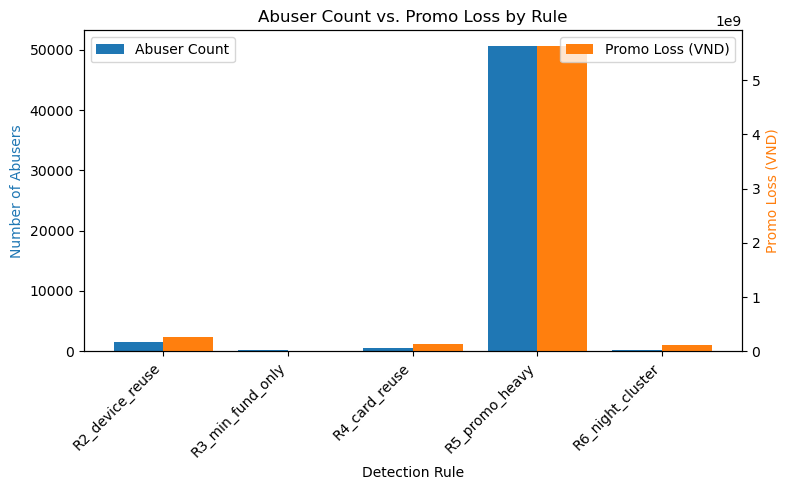

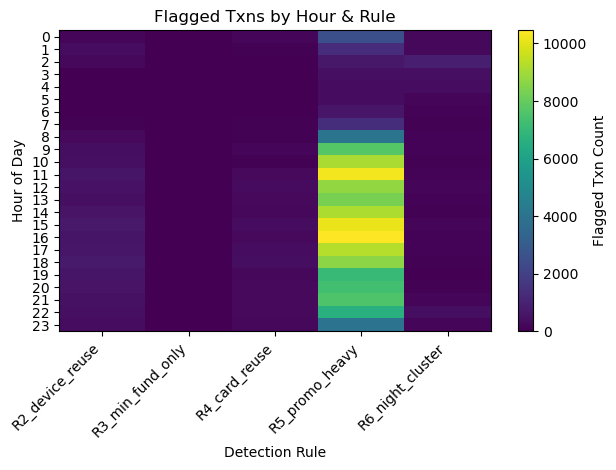

In [70]:
import numpy as np
# A. BAR CHART

abuser_counts = all_rules.groupby('reason')['userId'].nunique()
loss_by_rule  = (
    txn_enriched
      .merge(all_rules, on='userId')
      .groupby('reason')['discount_amount']
      .sum()
)

rules = abuser_counts.index.tolist()
x     = np.arange(len(rules))
width = 0.4
fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

ax1.bar(x - width/2, abuser_counts.values, width, label='Abuser Count',   color='tab:blue')
ax2.bar(x + width/2, loss_by_rule.values,  width, label='Promo Loss (VND)', color='tab:orange')

ax1.set_xlabel('Detection Rule')
ax1.set_ylabel('Number of Abusers',   color='tab:blue')
ax2.set_ylabel('Promo Loss (VND)', color='tab:orange')
ax1.set_xticks(x)
ax1.set_xticklabels(rules, rotation=45, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Abuser Count vs. Promo Loss by Rule')
plt.tight_layout()

plt.savefig('abusers_loss_combined.png')
plt.show()

# B. HEAT MAP
#    merge flags back to each transaction
flagged_txns = txn_enriched.merge(all_rules, on='userId')

#    pivot: rows = hour, cols = rule, values = count of txns
heat = (flagged_txns
        .groupby(['txn_hour','reason'])
        .size()
        .unstack(fill_value=0)
        .reindex(index=range(24), fill_value=0))  # ensure 0–23

plt.imshow(heat, aspect='auto')
plt.title('Flagged Txns by Hour & Rule')
plt.xlabel('Detection Rule')
plt.ylabel('Hour of Day')
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha='right')
plt.yticks(range(24), range(24))
plt.colorbar(label='Flagged Txn Count')
plt.tight_layout()
plt.savefig('heatmap_by_hour_rule.png')
plt.show()

In [82]:
# Mark each cashback txn as prevented if user is in real-time rule set:
real_time_rules = pd.concat([r1, r2, r3, r4], ignore_index=True)['userId'].unique()
cb_txns = txn_enriched[txn_enriched['discount_amount']==50000]

blocked = cb_txns[cb_txns['userId'].isin(real_time_rules)]
saved_promo = blocked['discount_amount'].sum()

# Estimate false positives: any txn by a legit user (not in result.xlsx) that would have been blocked
legit_txns = cb_txns[~cb_txns['userId'].isin(result['userId'])]
fp_count   = legit_txns['userId'].nunique()

print(f"Saved {saved_promo:,} VND; false positives: {fp_count} users")

# 1) Identify all users who actually got a 50k cashback
cb_txns = txn_enriched[txn_enriched['discount_amount'] == 50000]
cb_users = set(cb_txns['userId'])

# 2) Build sets
blocked_live = set(real_time_rules)
abusers_gt   = set(result['userId'])

# 3) Compute user‐level counts
TP_users = blocked_live & abusers_gt
FP_users = blocked_live - abusers_gt
FN_users = abusers_gt - blocked_live
TN_users = (set(txn_enriched['userId']) - abusers_gt) - FP_users

# 4) Promo amounts
saved_promo     = cb_txns[cb_txns['userId'].isin(TP_users)]['discount_amount'].sum()
fp_promo_lost   = cb_txns[cb_txns['userId'].isin(FP_users)]['discount_amount'].sum()

# 5) Assemble a DataFrame
sim_df = pd.DataFrame([
    ['True Positive (blocked bots)',        len(TP_users), len(TP_users)*50000, saved_promo],
    ['False Positive (blocked legit)',      len(FP_users), len(FP_users)*50000, fp_promo_lost],
    ['False Negative (missed bots)',        len(FN_users), len(FN_users)*50000, len(FN_users)*50000],
    ['True Negative (legit rewarded)',      len(TN_users), len(TN_users)*50000, (len(TN_users))*50000]
], columns=['Category','Users','Cashbacks','Promo Impact (VND)'])

print(sim_df.to_string(index=False))

Saved 117,850,000 VND; false positives: 2342 users
                      Category  Users  Cashbacks  Promo Impact (VND)
  True Positive (blocked bots)   2186  109300000           117850000
False Positive (blocked legit)      0          0                   0
  False Negative (missed bots)  49441 2472050000          2472050000
True Negative (legit rewarded)  38928 1946400000          1946400000
